# 算法简介

时间序列是指时间间隔不变情况下收集对时间点的集合，这些集合被用于分析以提供了一种预测未来价值的机会，由于时间序列有随时间呈现上升或下降的趋势，或特定的季节性趋势，通过曲线拟合和参数估计来建立数学模型的理论和方法，从而可以使用其来预测如国民宏观经济控制、气象预测、商品销售量等趋势。常见的时间序列预测算法包括如下几种：

>* 整合移动平均自回归模型（ARIMA）

>* Facebook开源的时序预测库（Prophet）

>* 线性回归算法（LR）

>* 回流神经网络（RNN）

>* 支持向量机模式（SVM）

>* 其它：如广义自回归条件异方差模型（GARCH）、长短期记忆模型（LSTM）等

由于时间等方面的原因，本报告中只使用ARIMA及其变种算法、Prophet算法及线性回归算法，其它算法待后续有时间再补充。
为了验证相关的时序数据算法的准确率，我们使用了某水电站的2011年～2017年历年月发电量数据作为测试数据。

# 数据探索

## 数据特征

我们先看看数据特征：

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import statsmodels.api as sm
import statsmodels.graphics.api as qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# 验证时间序列的平稳性
def verify_stationarity(timeseries):
    verify = True
    adf = adfuller(timeseries)
    output = pd.Series(adf[0:4], index=
                       ['Test Statistic','p-value','#Lags Used',
                        'Number of Observations Used'])
    test_result = adf[0]
    if adf[1] > 0.05:
        verify = False
    for key,value in adf[4].items():
        output['Critical Value(%s)'%key] = value
        if test_result > value:
            verify = False
    print('Dickey-Fuller测试结果：')    
    print(output)
    return verify

warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = 42, 16
default_font_size = rcParams['font.size']
rcParams['font.size'] = 22

dateparse = lambda datas: pd.datetime.strptime(datas, '%Y-%m')
data = pd.read_csv('月发电量.csv', parse_dates=['date'], 
                   index_col = ['date'], date_parser=dateparse)
print(data.head())

data.describe().T

/Users/heguangwu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


             #value
date               
2011-01-01  1144.72
2011-02-01  1260.63
2011-03-01  1153.82
2011-04-01  1799.91
2011-05-01  3362.01


,count,mean,std,min,25%,50%,75%,max
#value,84.0,2312.28381,948.027541,322.77,1384.95,2329.53,3232.5825,3616.62


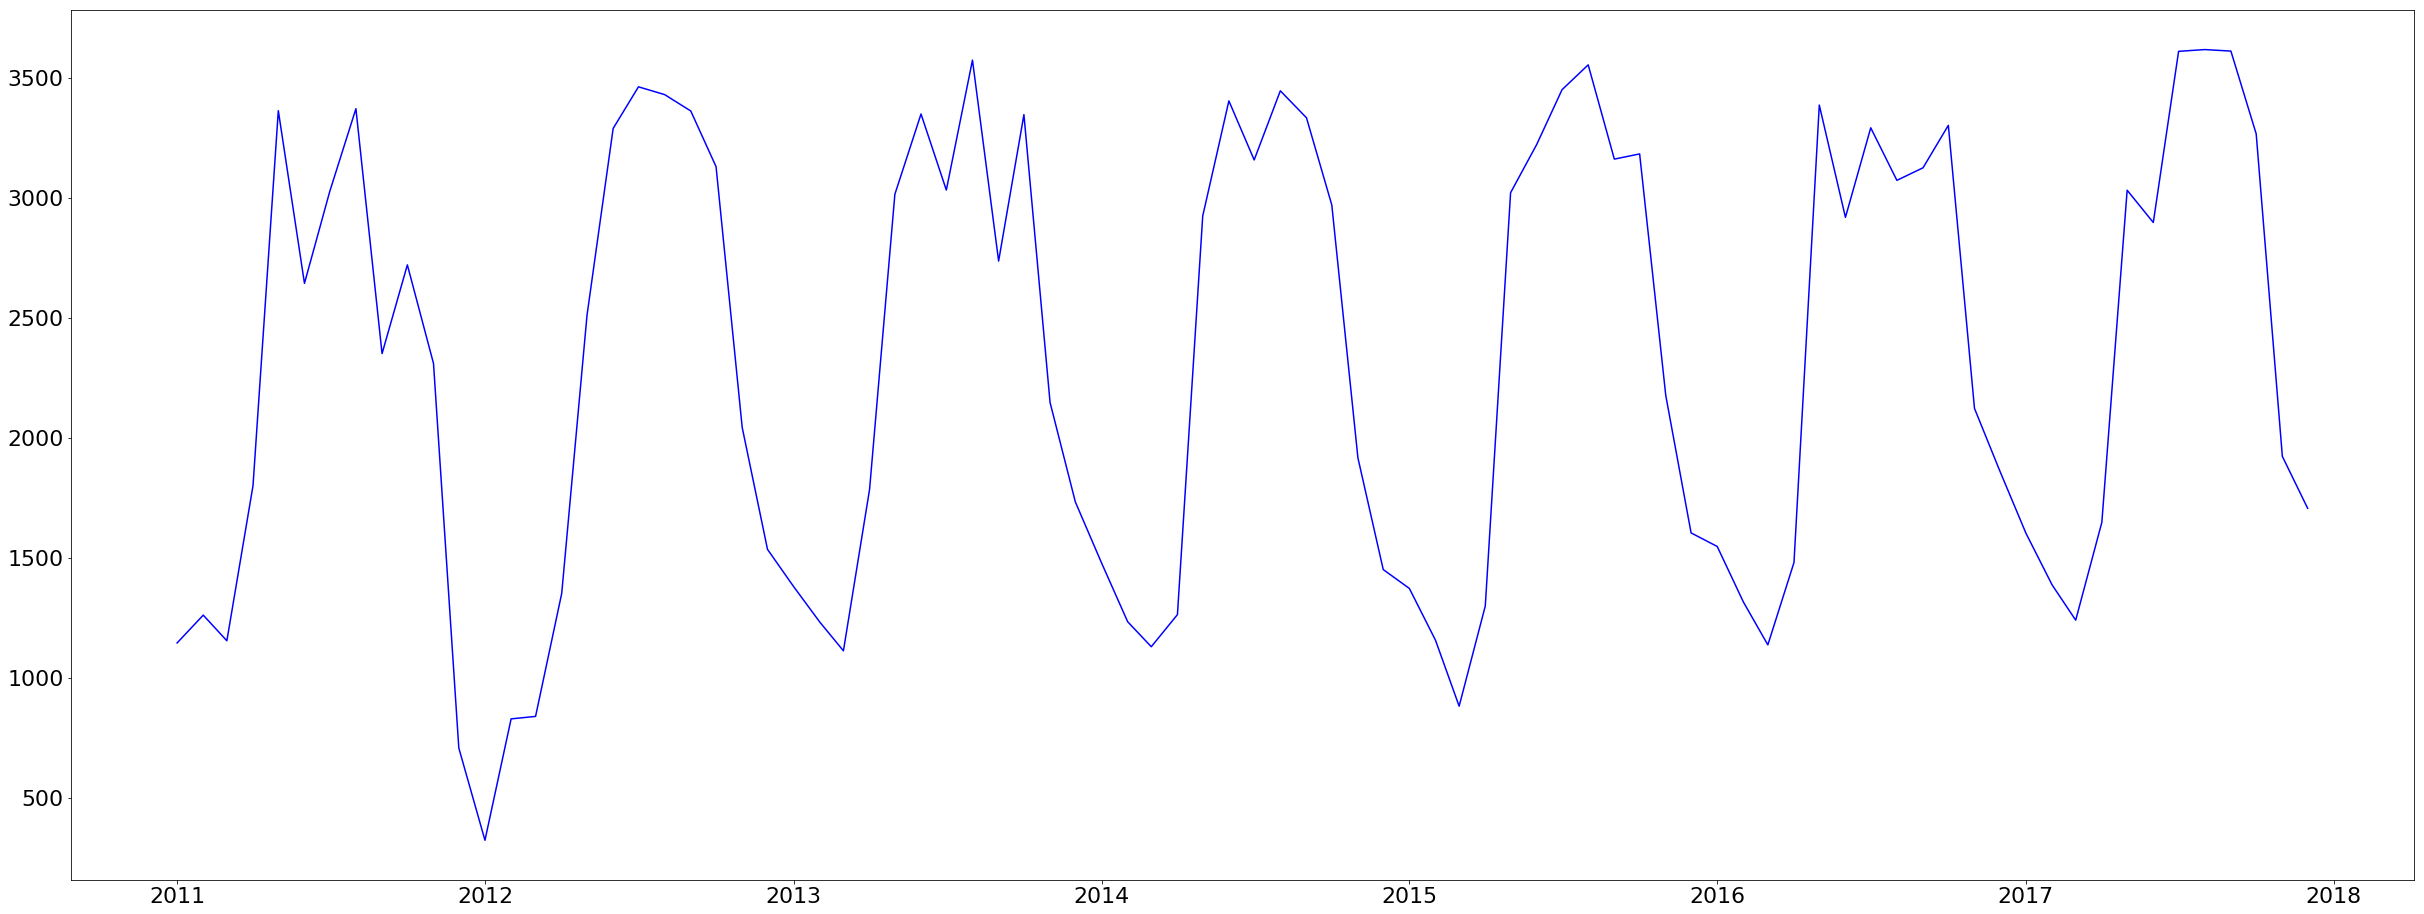

In [2]:
#原始数据曲线
orig = plt.plot(data, color='blue')
plt.show()

从上图可以看出，发电数据年中发电量高，年头和年尾较低。为更清晰看出数据的趋势，对时序数据进行分解后对图形如下：

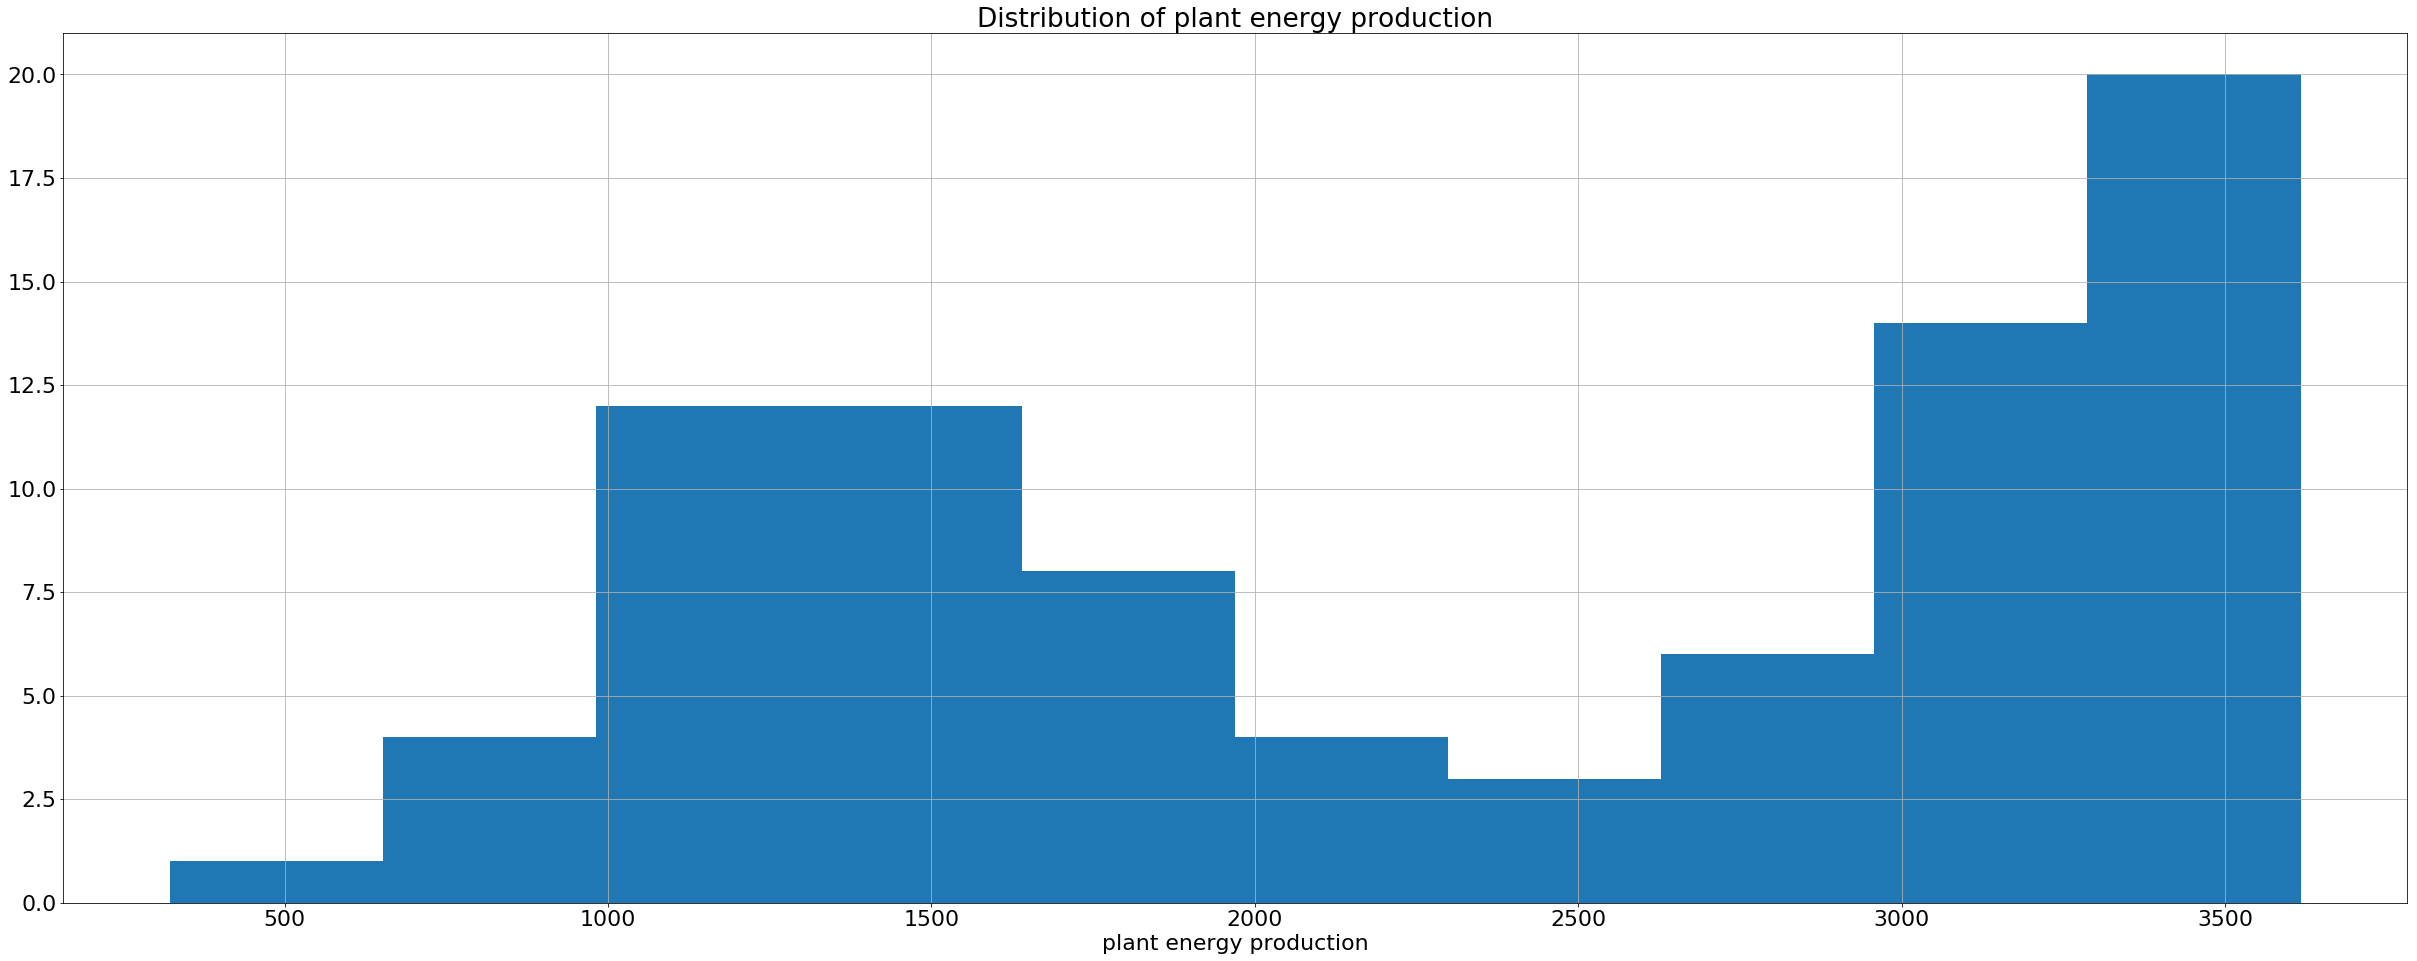

In [3]:
data.hist()  
plt.title('Distribution of plant energy production')  
plt.xlabel('plant energy production')  
plt.show()

查看发电量数据的直方图，数据表现出相当多的**负偏移**。在选择预测模型和评估时要牢记这一点，因为大多数基本的统计方法都**假定数据是正态分布的**。现在我们记住这个**异常特性，暂时不管它**。

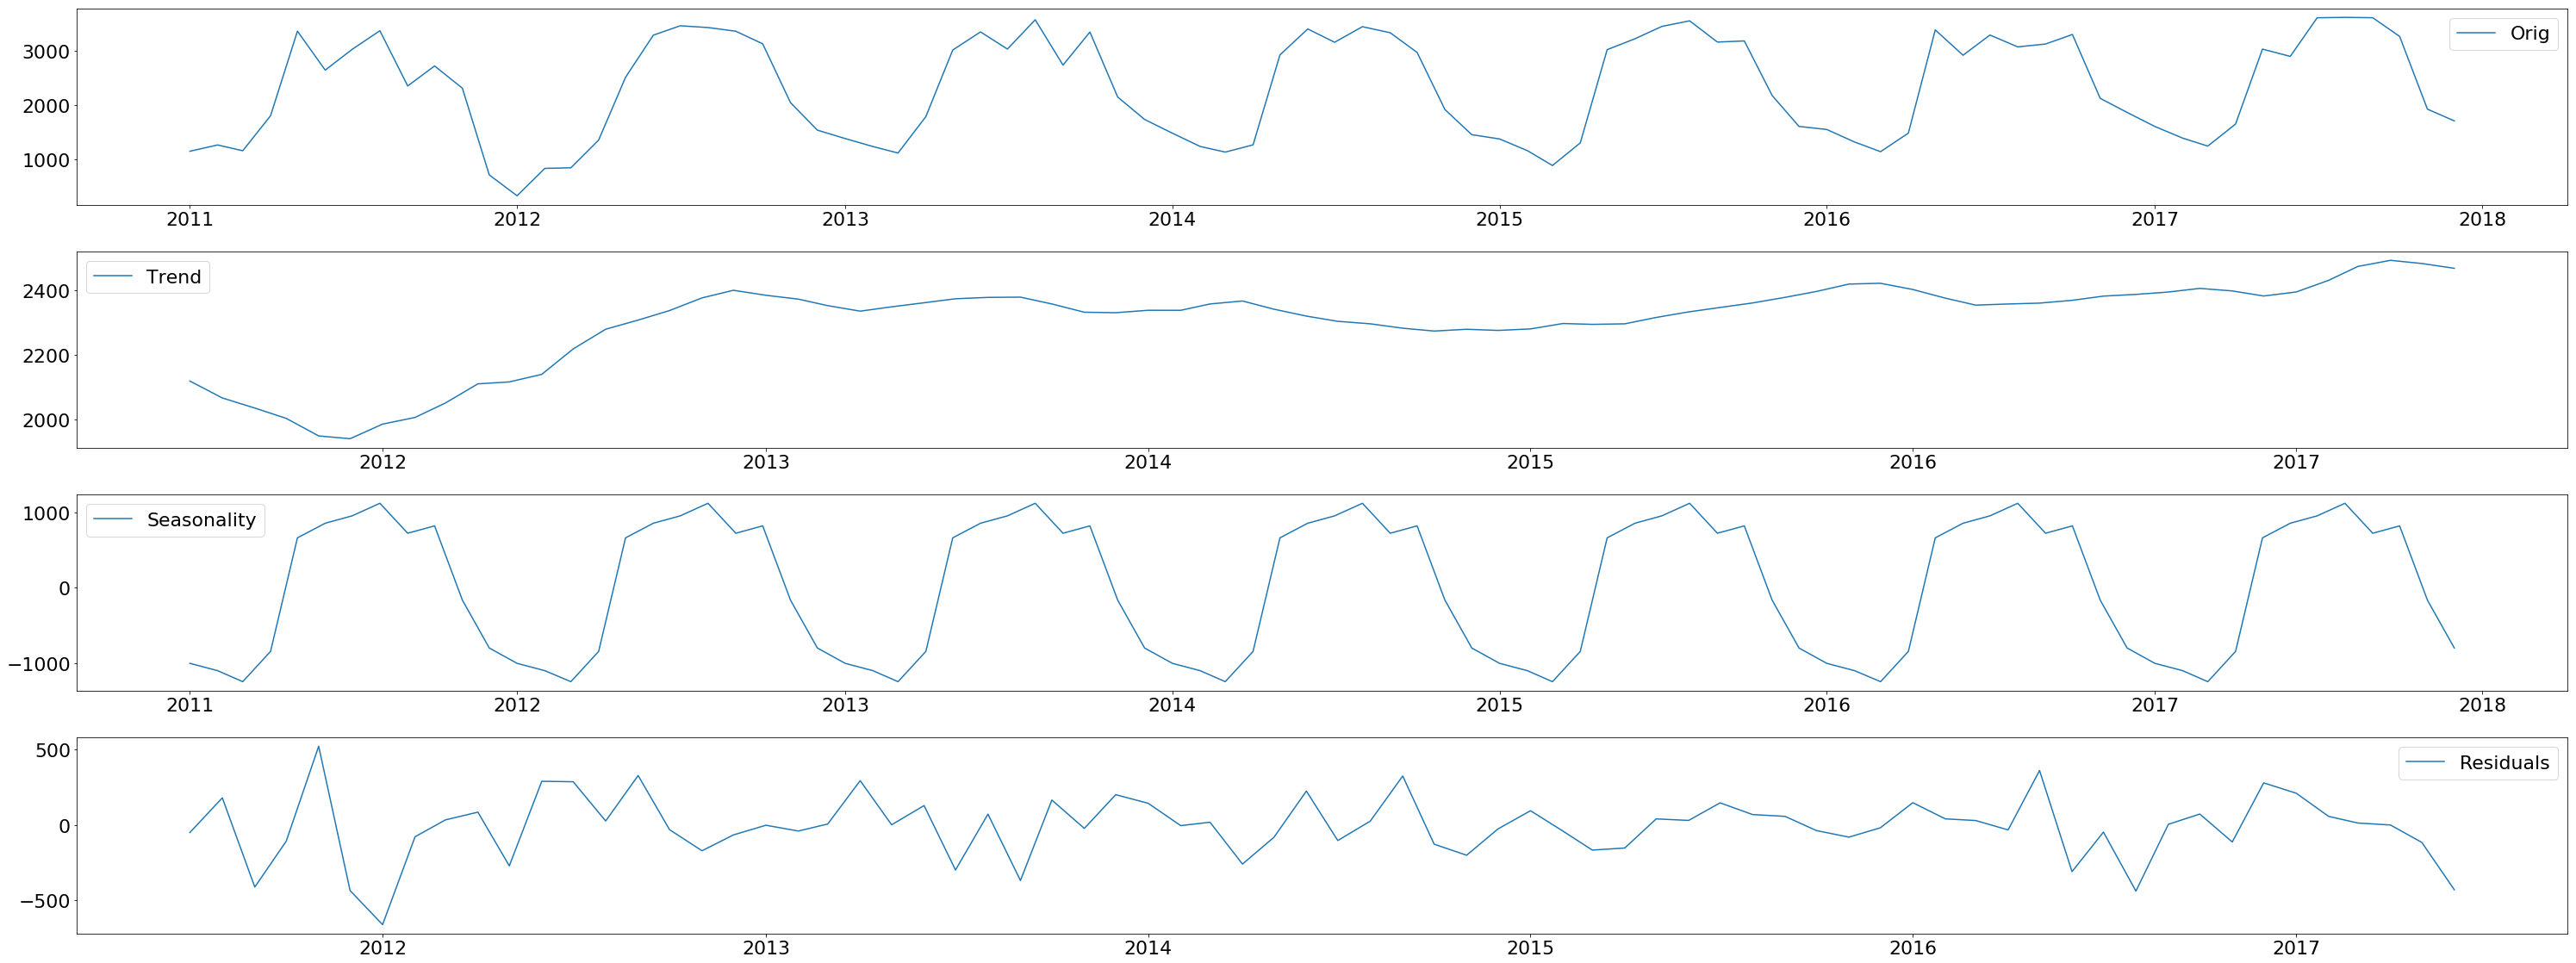

In [4]:
decomposition = seasonal_decompose(data)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(data, label='Orig') #原始数据
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend') #趋势
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality') #季节
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')  #残差
plt.legend(loc='best')
plt.tight_layout()

从上图可以很明显对看出该电站对时序数据特征如下：

>* 除了2012年外，该电站发电量呈现稳定上升趋势，上升趋势逐渐平缓，且有时部分下降趋势

>* 季节性变化趋势明显，年中最高符合新疆雨季特征

>* 残差不是很稳定，上下波动较大

经查证，2012年极寒天气袭扰新疆导致较大的降雪和降温，猜测可能是天气原因影响电站来水量等导致发电量相比其它年份偏低。

## 平稳处理

因为ARIMA模型要求时间序列为平稳，而我们通过上述的观察发现数据是有变化趋势的，即不是平稳数据，所以需要对数据进行处理使其平稳，对季节性变化的数据一般采用差分方式将其平稳化，并通过ADF校验判断其是否已经平稳。

In [5]:
ts = data['#value']
verify_stationarity(ts)

Dickey-Fuller测试结果：
Test Statistic                 -2.069159
p-value                         0.257095
#Lags Used                     12.000000
Number of Observations Used    71.000000
Critical Value(1%)             -3.526005
Critical Value(5%)             -2.903200
Critical Value(10%)            -2.588995
dtype: float64


False

从输出信息可以看出，p-value值较大，不满足条件，一般通过取对数来消除趋势以减少p-value。

In [6]:
ts_log = np.log(ts)
verify_stationarity(ts_log)

Dickey-Fuller测试结果：
Test Statistic                 -2.869283
p-value                         0.049038
#Lags Used                     12.000000
Number of Observations Used    71.000000
Critical Value(1%)             -3.526005
Critical Value(5%)             -2.903200
Critical Value(10%)            -2.588995
dtype: float64


False

从输出可以看出p-value降低了，但ADF检验还是未通过，原因是1%、5%、10%不同程度拒绝原假设的统计值和ADF test statistic的比较不通过。接下来使用差分方法来消除季节性趋势，因为水电站的发电量和来水量是紧密相关的，来水量一般是年度重复性，所以这里采用减去一年前的时间点数据，即减去12。

In [7]:
ts_log_diff = ts_log.diff(12).dropna()
verify_stationarity(ts_log_diff)

Dickey-Fuller测试结果：
Test Statistic                 -4.584036
p-value                         0.000138
#Lags Used                      1.000000
Number of Observations Used    70.000000
Critical Value(1%)             -3.527426
Critical Value(5%)             -2.903811
Critical Value(10%)            -2.589320
dtype: float64


True

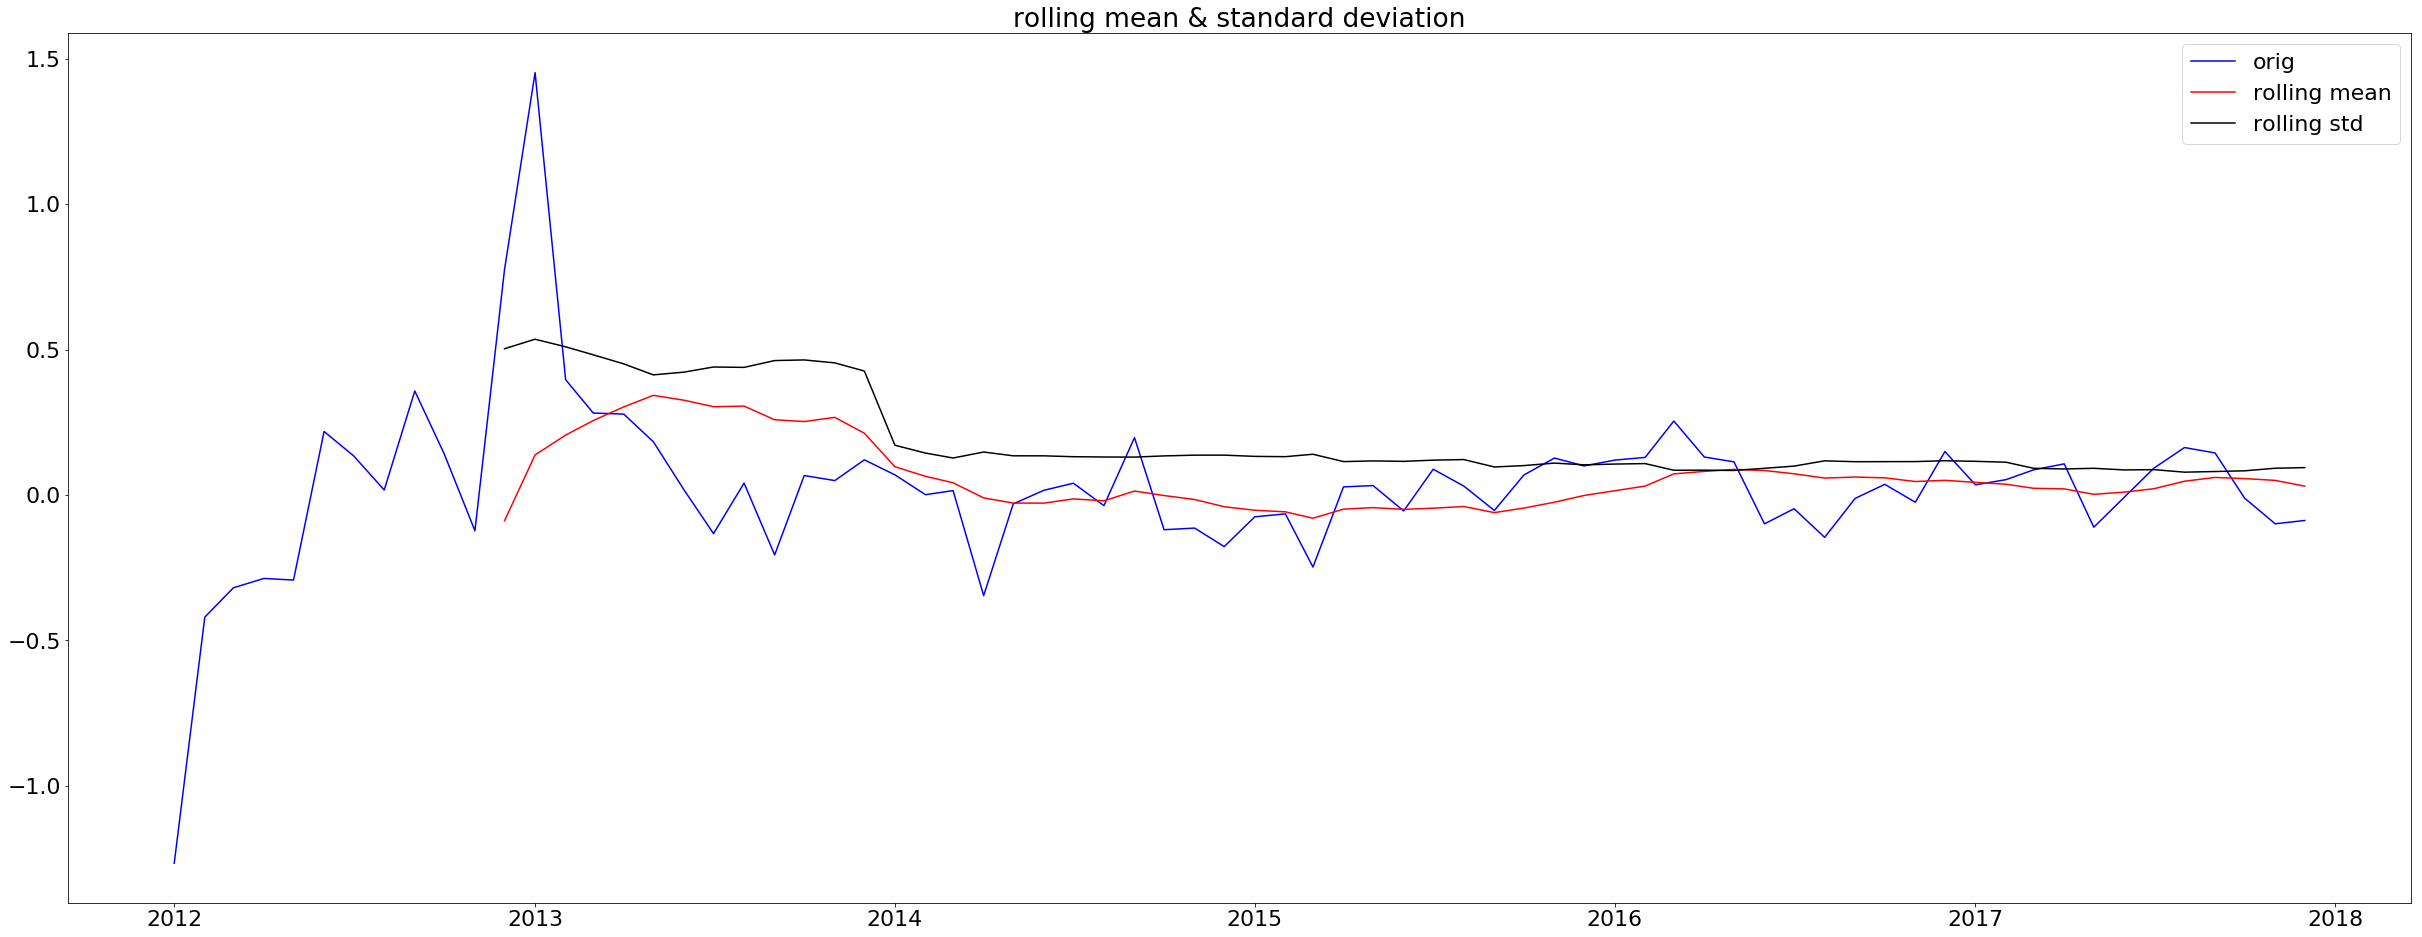

In [8]:
# 计算移动平均误差，窗口大小为1年
rolmean = pd.rolling_mean(ts_log_diff, window = 12)
rolstd = pd.rolling_std(ts_log_diff, window = 12)
o = plt.plot(ts_log_diff, color='blue',label='orig')
m = plt.plot(rolmean, color='red', label = 'rolling mean')
s = plt.plot(rolstd, color = 'black', label = 'rolling std')
plt.legend(loc='best')
plt.title('rolling mean & standard deviation')
plt.show(block=False)

这里采用的是年平均数，从上图可以看出，平均值和标准方差在2014年之前波动较大，之后基本平稳，推测在2014年之后电站运行逐渐走入正轨。

# ARIMA算法

ARIMA计算的一般步骤：

1.获取被观测系统时间序列数据

2.对数据绘图，观测是否为平稳时间序列；对于非平稳时间序列要先进行d阶差分运算，化为平稳时间序列

3.经过第二步处理得到平稳时间序列。分别求得其自相关系数ACF和偏自相关系数PACF，通过对自相关图和偏自相关图的分析，得到最佳的阶层 p 和阶数 q

4.由以上得到的d、q、p ，得到ARIMA模型。然后开始对得到的模型进行模型检验

所以ARIMA算法的一个重要问题就是确定“p“值和”q“值，这里使用自相关函数ACF和部分自相关函数PACF来确定这两个值。

## ACF && PACF

ACF和PACF的数学定义不在此描述，其本身就是用于确定平稳性和q、p值的。

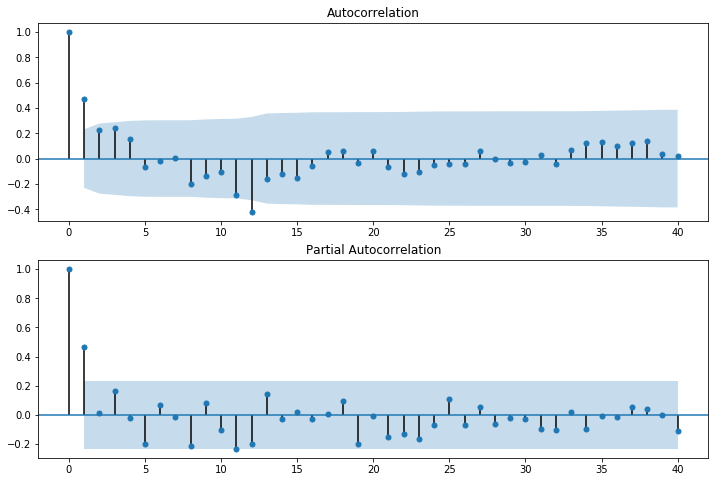

In [9]:
rcParams['font.size'] = default_font_size
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff, lags=40, ax=ax2)

从上图可以看出，ACF只有一个点（第12点）超过了置信边界，PACF基本都值置信区间内。也就是说，可以近似认为ACF拖尾，PACF在1阶后截尾。从而确定p、q值都为1。这个图可能还不是非常清晰，使用另外一种方式画图如下。

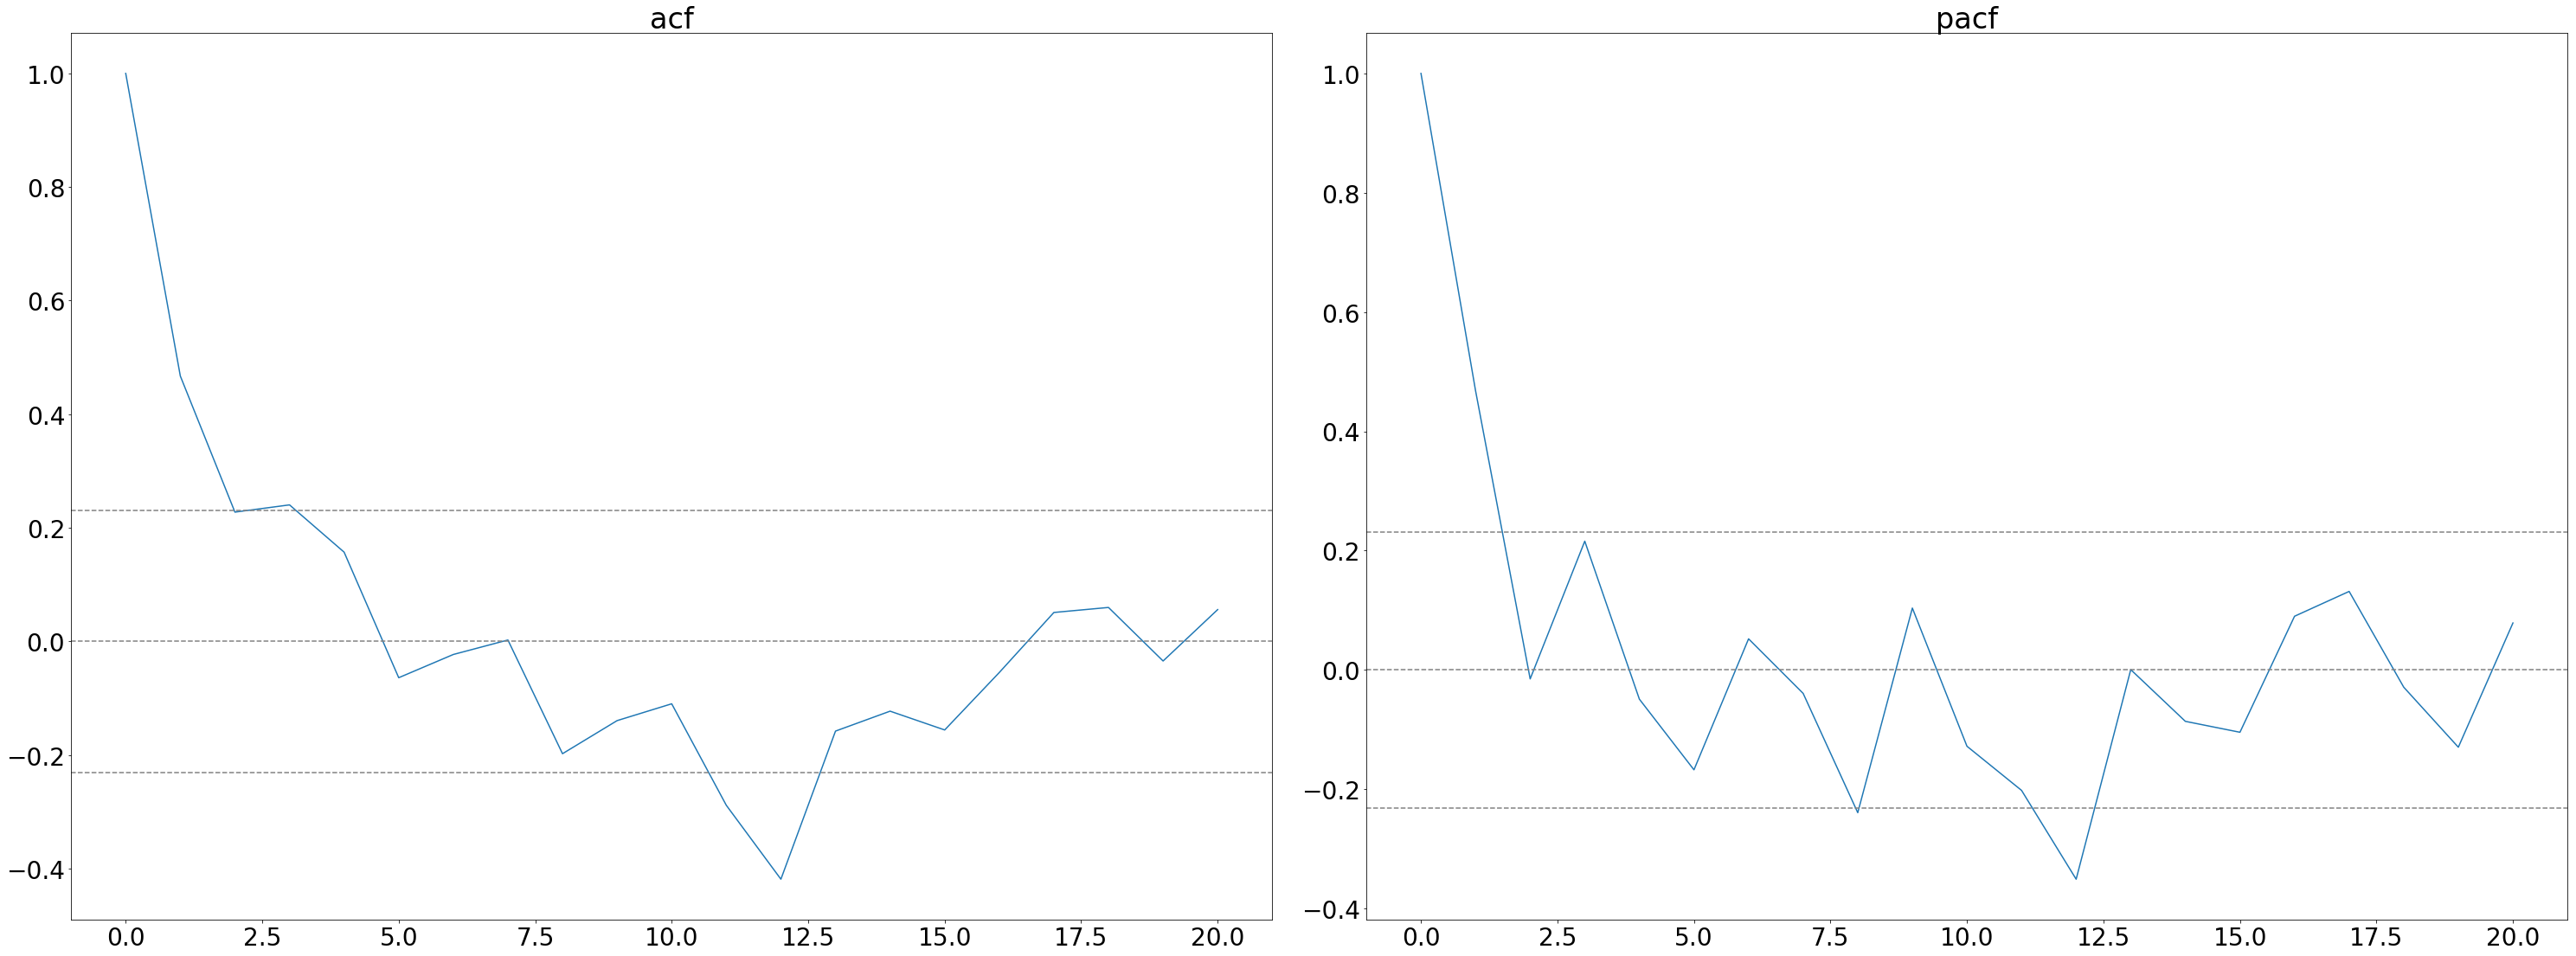

In [10]:
rcParams['font.size'] = 28
lag_acf = acf(ts_log_diff, nlags = 20)
lag_pacf = pacf(ts_log_diff, nlags = 20, method='ols')
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('acf')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('pacf')

plt.tight_layout()

上图两条虚线之间为置信区间，从上图看，acf/pacf函数第一次截断在置信区间大约在1～2之间的位置，实际上，我们不是看图来决定，而是使用循环计算得到最优的p、q值（p、q值不宜设置过大，过大导致计算复杂，一般p、q都在10以内都较小值）。

In [11]:
# 使用给定的(p,d,q)对ARIMA模型进行评估
def evaluate_arima_model(X, arima_order):
    # 划分训练数据和测试数据，一般是7、3开
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # 计算MSE
    error = mean_squared_error(test, predictions)
    return error

#找出最小均方误差的(p,d,q)
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)
#print(ts_log_diff.values)
evaluate_models(ts_log_diff.values, p_values, d_values, q_values)    

ARIMA(0, 0, 0) MSE=0.011
ARIMA(0, 0, 1) MSE=0.010
ARIMA(0, 0, 2) MSE=0.009
ARIMA(0, 0, 3) MSE=0.011
ARIMA(0, 1, 0) MSE=0.012
ARIMA(0, 1, 1) MSE=0.012
ARIMA(0, 1, 2) MSE=0.012
ARIMA(0, 1, 3) MSE=0.013
ARIMA(1, 0, 0) MSE=0.009
ARIMA(1, 0, 1) MSE=0.009
ARIMA(1, 0, 3) MSE=0.011
ARIMA(1, 1, 0) MSE=0.011
ARIMA(1, 1, 1) MSE=0.010
ARIMA(1, 1, 2) MSE=0.011
ARIMA(2, 0, 0) MSE=0.009
ARIMA(2, 0, 1) MSE=0.011
ARIMA(2, 0, 2) MSE=0.011
ARIMA(2, 1, 0) MSE=0.013
ARIMA(2, 1, 1) MSE=0.013
ARIMA(3, 0, 0) MSE=0.011
ARIMA(3, 0, 1) MSE=0.011
ARIMA(3, 0, 2) MSE=0.018
ARIMA(3, 0, 3) MSE=0.010
ARIMA(3, 1, 0) MSE=0.014
ARIMA(3, 1, 1) MSE=0.014
ARIMA(3, 1, 2) MSE=0.023
Best ARIMA(1, 0, 0) MSE=0.009


上述计算结果可以看出，实际上我们使用AR模型即可，因为(p,q)值在（1，0）时和（1，1）时MSE基本一样。我们最终还是使用ARIMA模型（因为测试得到AR模型比ARIMA模型结果要差），参数为（1，0，1）来预测看看结果如何。

## 数据预测

对训练数据使用该模型进行拟合及初步判断。

                              ARMA Model Results                              
Dep. Variable:                 #value   No. Observations:                   72
Model:                     ARMA(1, 1)   Log Likelihood                   0.221
Method:                       css-mle   S.D. of innovations              0.240
Date:                Fri, 19 Jan 2018   AIC                              7.559
Time:                        10:11:18   BIC                             16.665
Sample:                    01-01-2012   HQIC                            11.184
                         - 12-01-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0029      0.068      0.043      0.966      -0.131       0.137
ar.L1.#value     0.4921      0.300      1.641      0.105      -0.096       1.080
ma.L1.#value     0.2114      0.366      0.57

Text(0.5,1,'RSS: 4.7980')

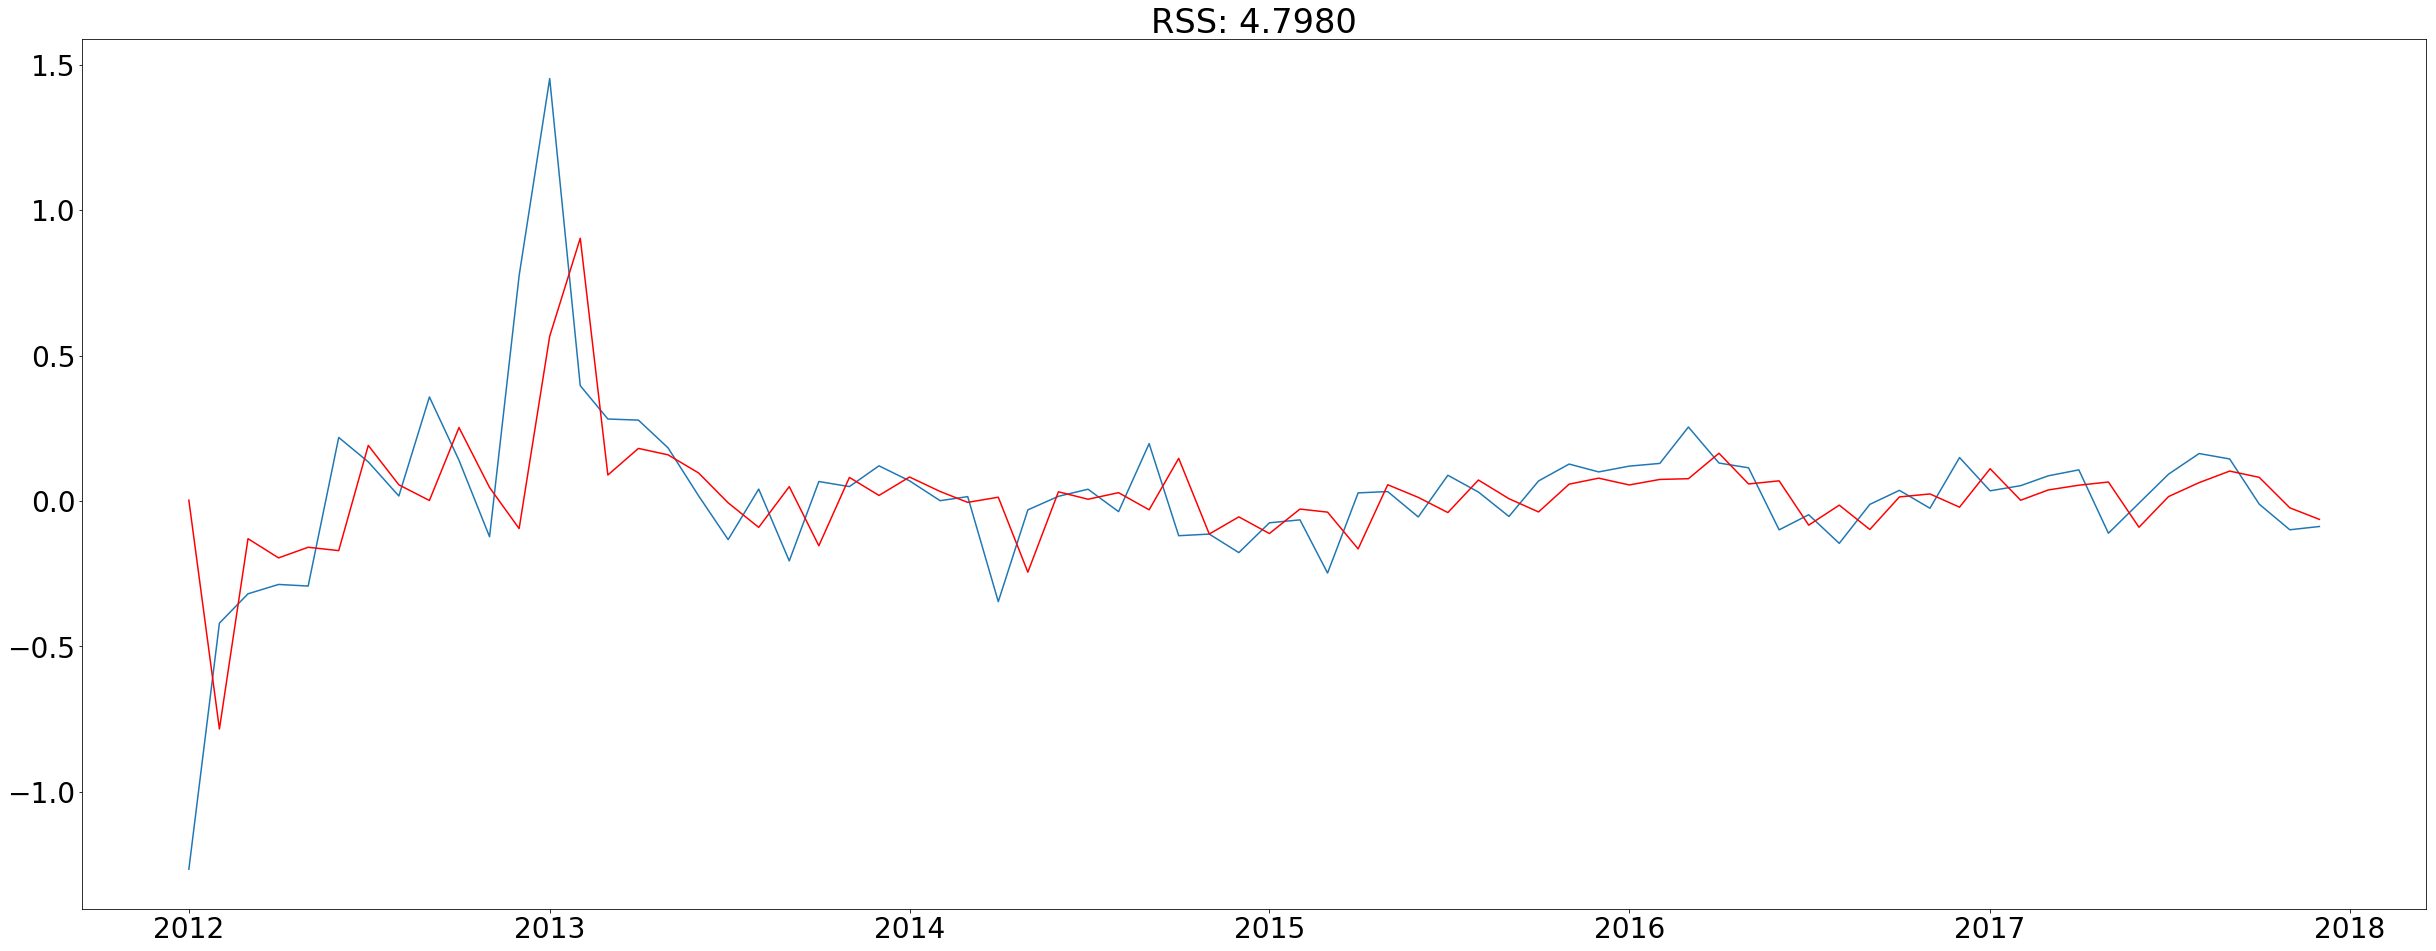

In [12]:
model = ARIMA(ts_log_diff, order = (1, 0, 1))
model_fit = model.fit(disp = 0)
print(model_fit.summary())
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((model_fit.fittedvalues - ts_log_diff) ** 2))

从上面显示的结果看，P值过大（远大于0.5），说明评估假设检验不通过，此外，图上的RSS显示这也不是一个很理想的结果，整个图上的曲线显示也可以看出算法的效果不是很理想。所以这里将数据还原后再取和原始数据对比看实际效果。

Text(0.5,1,'MSE : 63371.86')

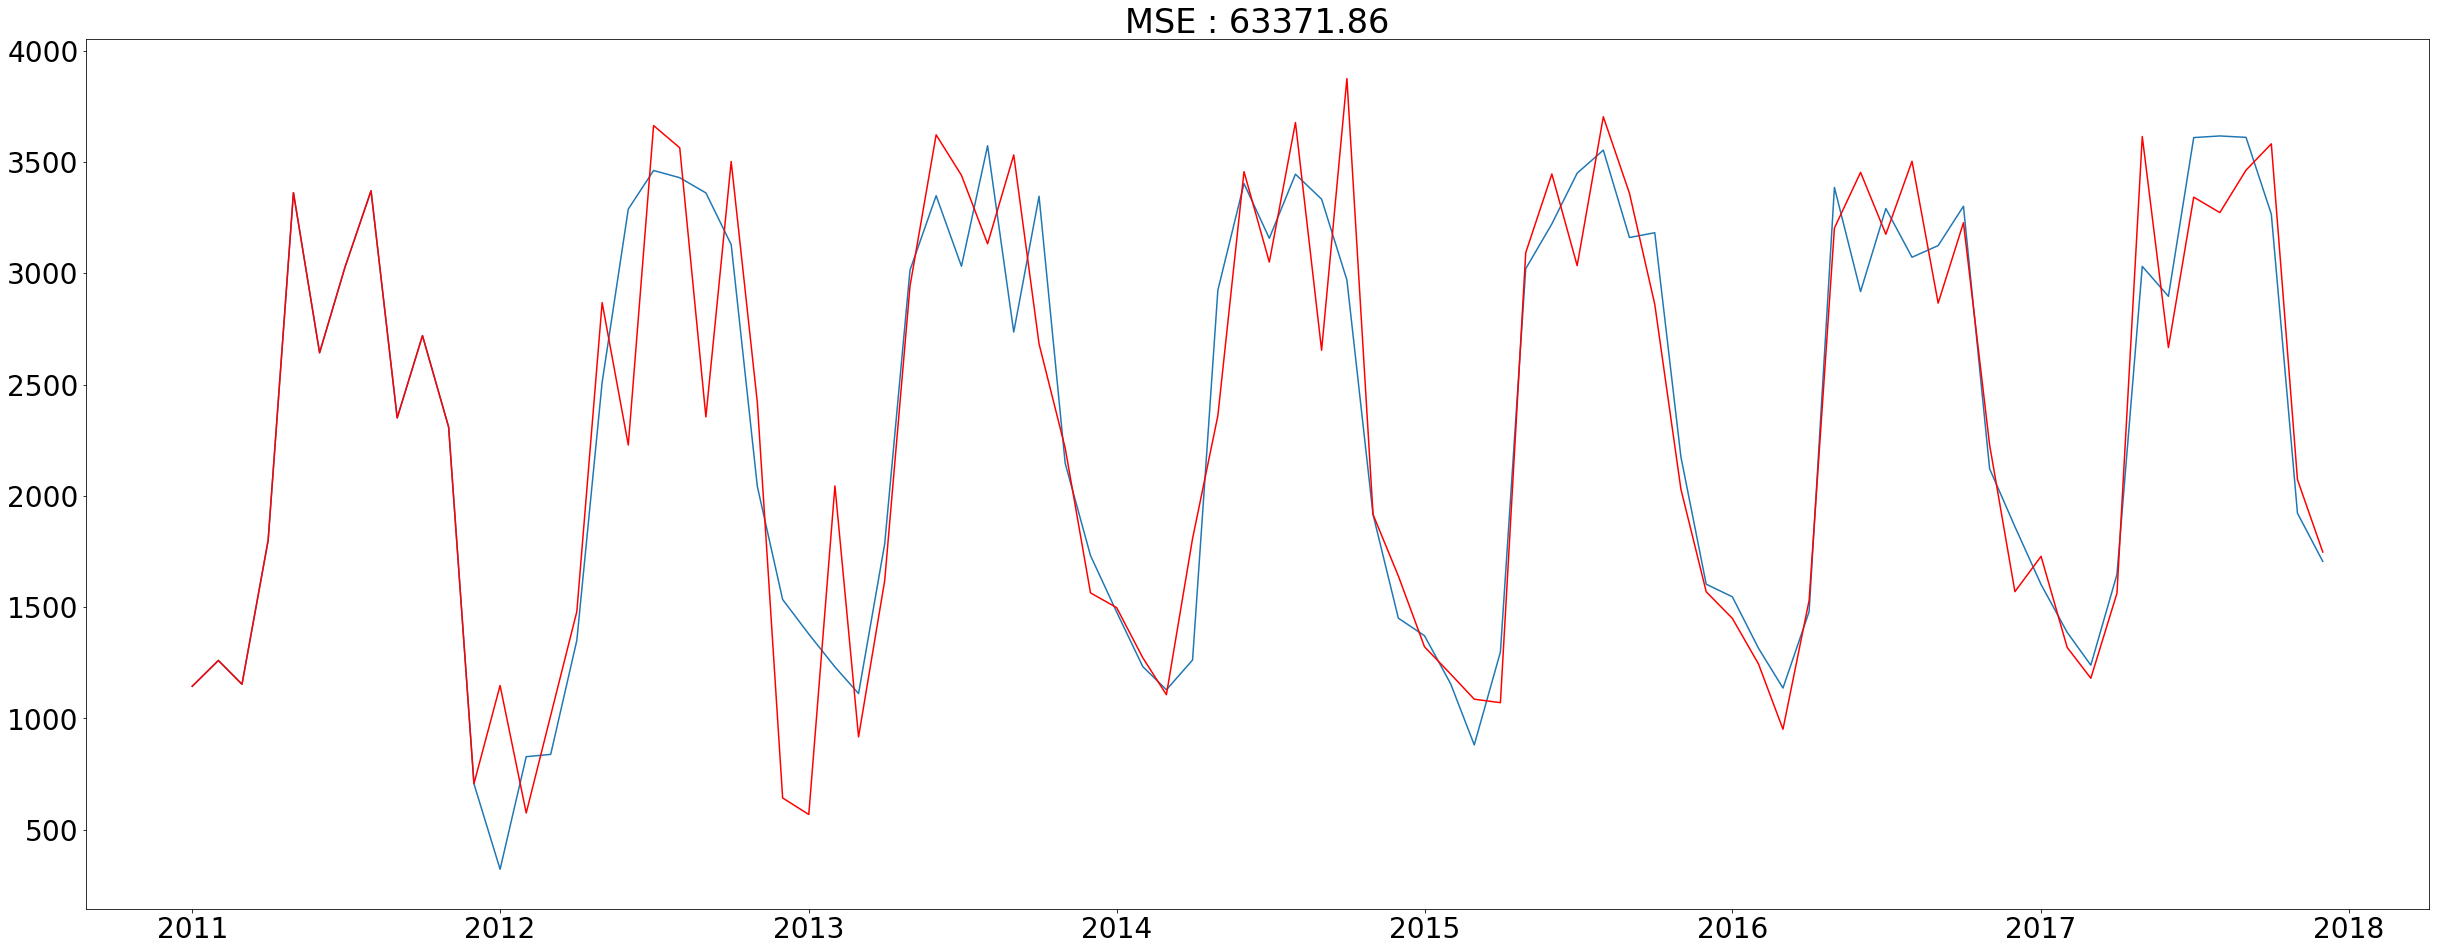

In [13]:
def data_restore(timeseries):
    predict_value = timeseries
    periods = 12
    
    restored = ts_log.copy()
    restored.iloc[periods:] = np.nan
    i = 0
    for d in predict_value.index:
        diff_date = d - pd.DateOffset(months=periods)
        restored.iloc[i + periods] = np.exp(ts_log[diff_date] + 
                                            predict_value.values[i])
        i = i + 1
    #还原最初的一年的数据
    restored.iloc[:periods] = ts[:periods]
    return restored

restored = data_restore(model_fit.fittedvalues)
#res = pd.concat([ts_log, predict_value, restored], axis = 1)
#res.columns = ['orig','diffs','restored']

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(restored[-12:], ts[-12:])

plt.plot(ts, label = 'orig')
plt.plot(restored, color='red', label='predict')
plt.title('MSE : %.2f' %(mse))

从曲线拟合效果及MSE的结果看也不是很理想。下面先尝试预测2018年1月和2月份的发电量，到时候再和实际的发电量来进一步评估误差。

In [14]:
def restore_sigle_value(fore_diff, add):
    forecasted = np.exp(fore_diff + add)
    return forecasted

forecasted_log_diff = model_fit.forecast(2)[0]
forecasted_1 = restore_sigle_value(forecasted_log_diff[0], ts_log[-12])
forecasted_2 = restore_sigle_value(forecasted_log_diff[0], ts_log[-11])
print('ARIMA算法预测2018年一月份发电量为：%.2f, 二月份发电量为：%.2f'
      %(forecasted_1, forecasted_2))

ARIMA算法预测2018年一月份发电量为：1528.71, 二月份发电量为：1323.49



## SARIMAX算法

SARIMA算法是ARIMA季节性算法，减少程序中大量的其它代码如差分等。这里简单介绍其计算流程如下。

首先也是计算最优的p、d、q值，这里也是使用暴力计算。

In [15]:
import itertools
import sys

def pdq_loop():
    p = range(0, 4)
    d = range(0, 2)
    q = range(0, 4)

    pdqs = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) 
                    for x in list(itertools.product(p, d, q))]

    aic_init = sys.float_info.max
    pdq_str = ''
    for pdq in pdqs:
        for s_pdq in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, order=pdq, 
                                            seasonal_order=s_pdq,
                                            enforce_stationarity=False,
                                           enforce_invertibility = False)
                result = mod.fit()
                if result.aic < aic_init:
                    aic_init = result.aic
                    pdq_str = 'SARIMAX{}{} - AIC:{}'.format(pdq, s_pdq, result.aic)
            
            except Exception as e:
                #print('exception:{}'.format(str(e)))
                continue
    return pdq_str
                
#print(pdq_loop())

根据输出结果显示，SARIMAX(3, 1, 1)(3, 1, 0, 12)产生最小的AIC值为，是所有模型中的最优参数，我们使用该模型生成预测数据看看输出情况。

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1561      0.185     -0.844      0.399      -0.519       0.207
ar.L2          0.0905      0.148      0.611      0.541      -0.200       0.381
ar.L3         -0.1726      0.232     -0.743      0.458      -0.628       0.283
ma.L1         -1.0000      0.388     -2.576      0.010      -1.761      -0.239
ar.S.L12      -0.7365      0.194     -3.797      0.000      -1.117      -0.356
ar.S.L24      -0.4267      0.147     -2.900      0.004      -0.715      -0.138
ar.S.L36      -0.0155      0.095     -0.163      0.871      -0.202       0.171
sigma2      3.599e+04   1.08e-05   3.34e+09      0.000     3.6e+04     3.6e+04


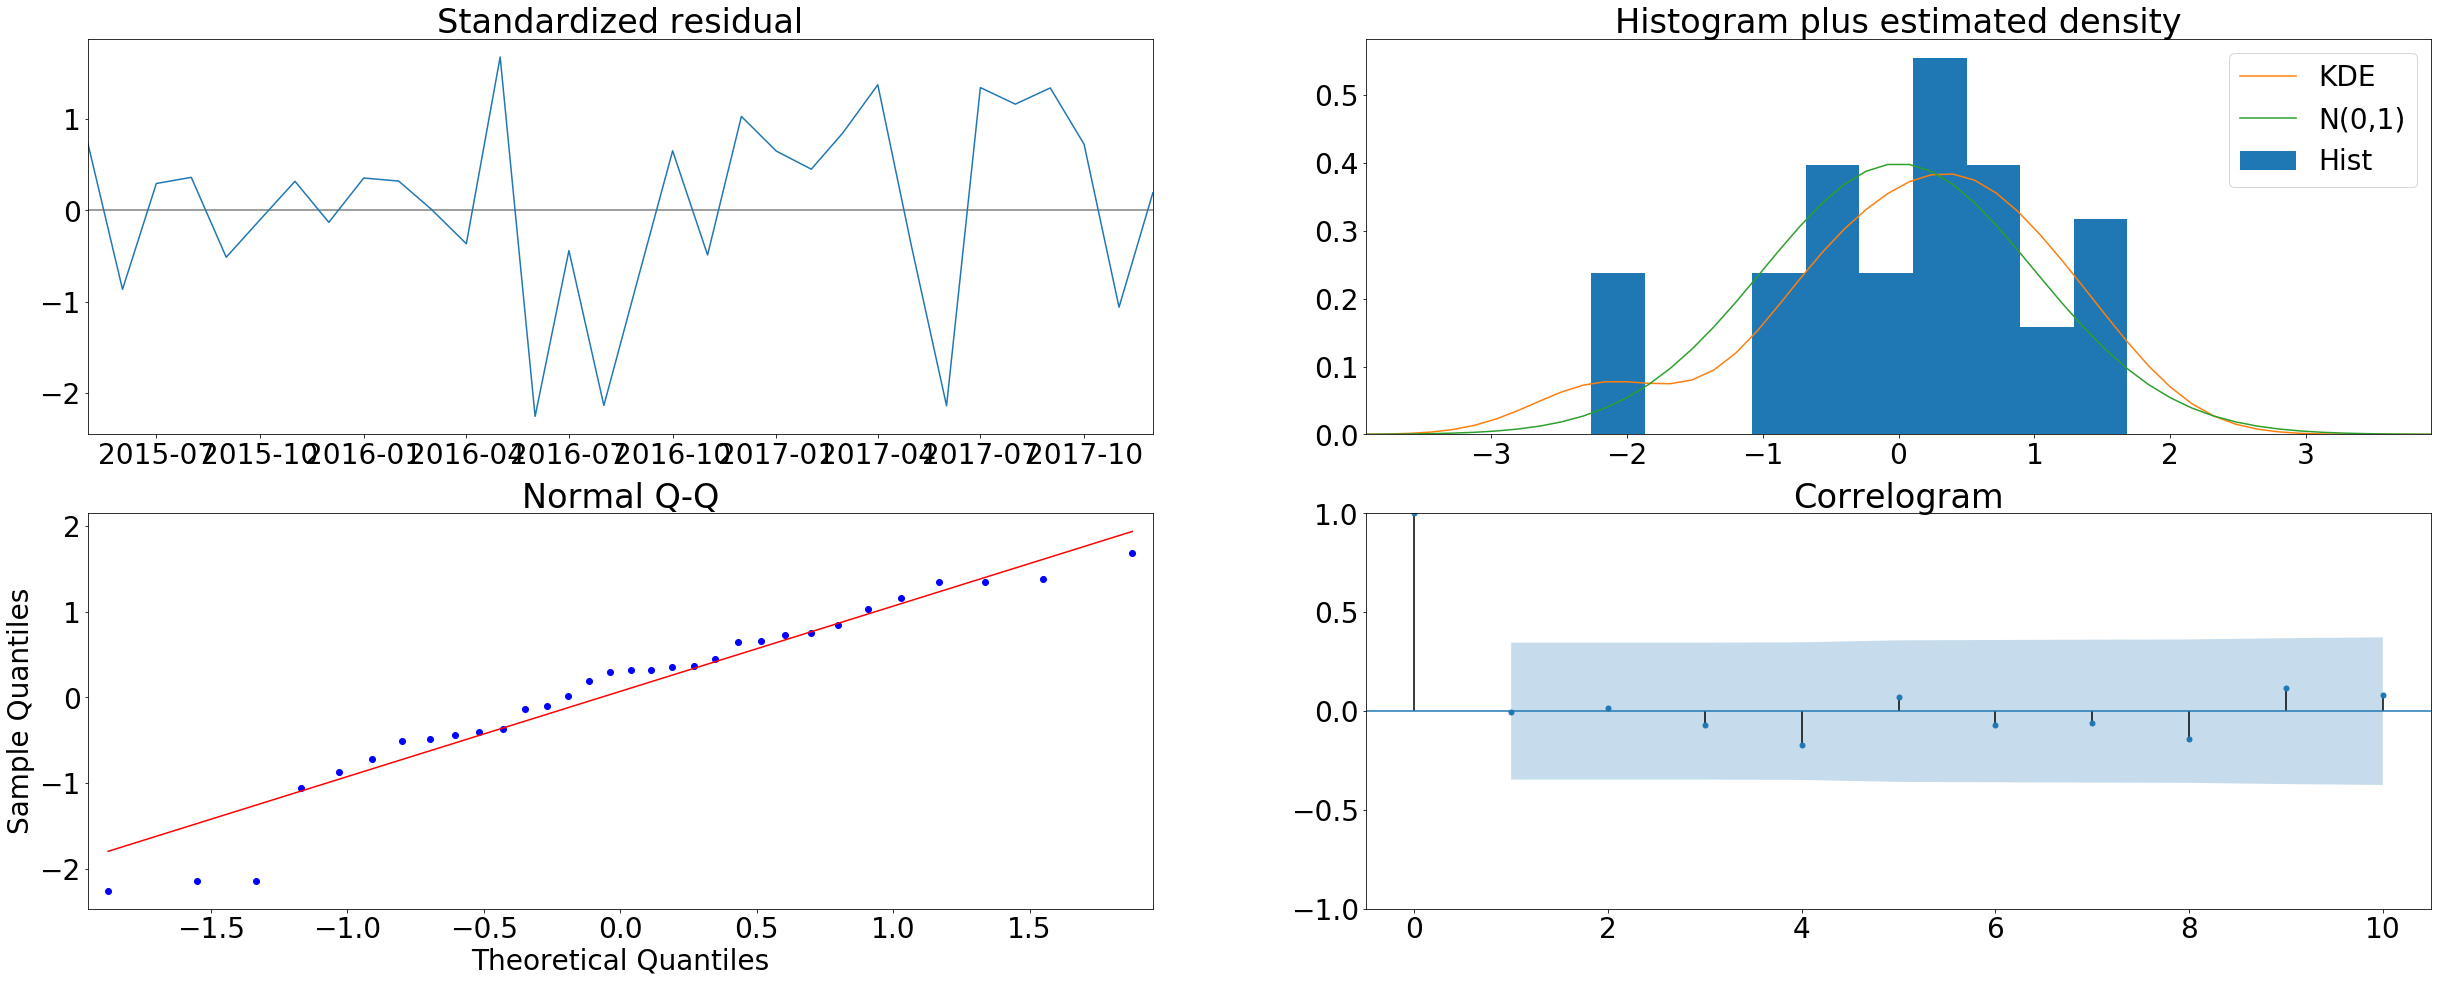

In [16]:
mod = sm.tsa.statespace.SARIMAX(ts, order=(3, 1, 1), 
                                seasonal_order=(3, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility = False)
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics()
plt.show()

上述输出主要说明：

1、summary输出coef列显示每个特征的重要性及每个特征是如何影响时间序列的，重点关注P>|z|列的值是否小于或接近于0.05

2、左上图主要关心模型的残差是不相关且平均分布为0（显示不够好），右上图KDE和N（0，1）基本是正态分布（基本满足）

3、左下图实际上也是残差（蓝点）分布情况，部分点偏的比较大。右下图是自相关的图就是前面所述的ACF

从模型来看，效果只能说是一般。这里我们从2017年的数据来预测看看实际效果。

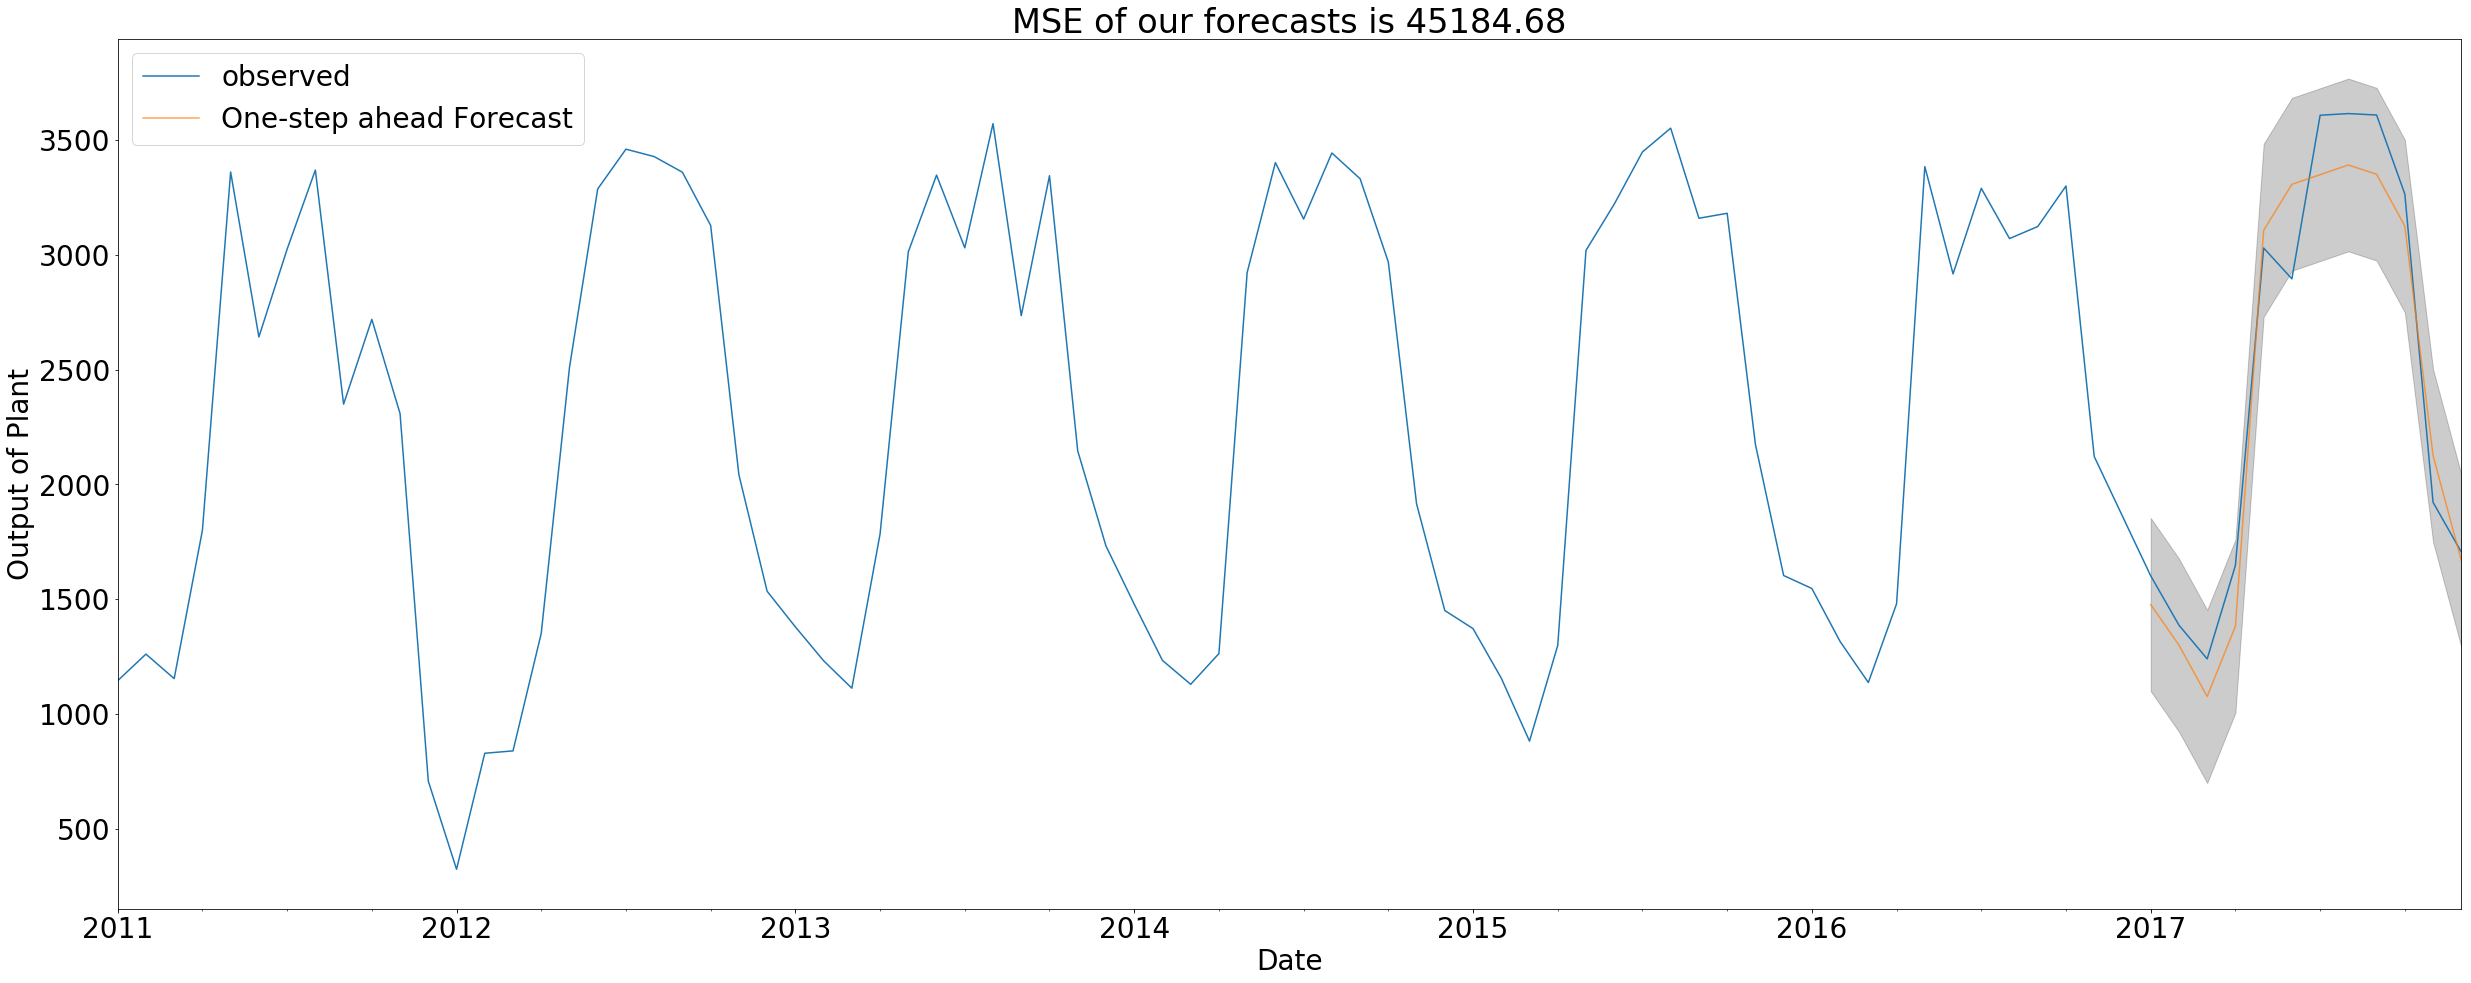

In [17]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = ts['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

y_forecasted = pred.predicted_mean
y_truth = ts['2017-01':]

from sklearn.metrics import mean_squared_error
mse_s = mean_squared_error(y_forecasted, y_truth)

ax.set_xlabel('Date')
ax.set_ylabel('Output of Plant')
ax.set_title('MSE of our forecasts is %.2f' %(mse_s))
plt.legend()
plt.show()

可以看出趋势基本一致，灰色是置信区间。但和之前一样，在发电高、低峰期但预测偏差很大，这里我们同样看看MSE的大小远远大于0，说明预测误差很大。上述是采用静态预测方式，实际工程中要使用动态预测，其处理如下：

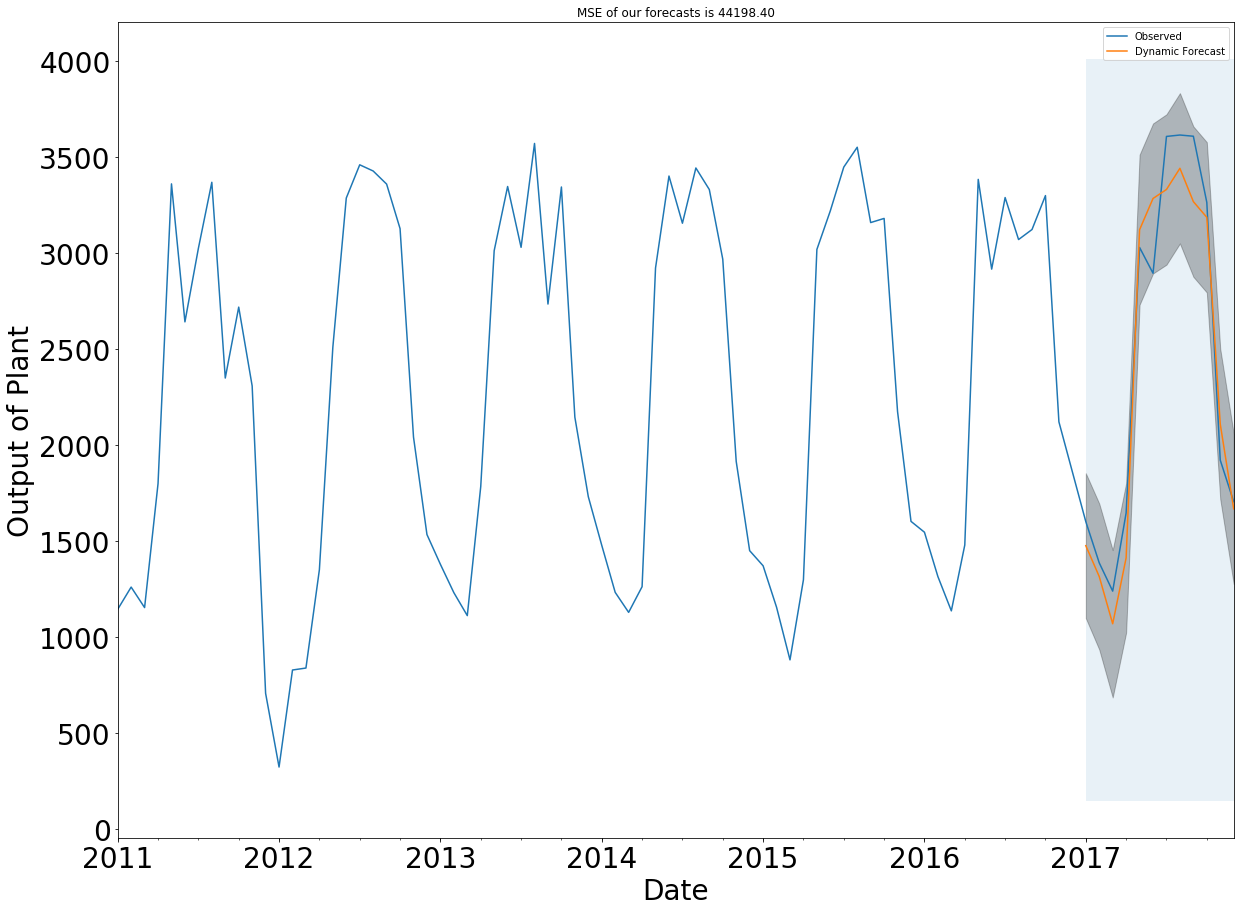

In [18]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2017-01-01'), 
                                      dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()
ax = ts['2011':].plot(label='Observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), ts.index[-1],
                 alpha=.1, zorder=-1)

y_forecasted_d = pred_dynamic.predicted_mean
y_truth_d = ts[-12:]

from sklearn.metrics import mean_squared_error
mse_d = mean_squared_error(y_forecasted_d, y_truth_d)

rcParams['font.size'] = default_font_size
ax.set_xlabel('Date')
ax.set_ylabel('Output of Plant')
ax.set_title('MSE of our forecasts is %.2f'%(mse_d))
plt.legend()
plt.show()

同样可以看到误差很大，这里我们也同样对2018年一月和二月对数据进行预测看看和ARIMA预测对结果比较看看。

In [19]:
pred_uc = results.forecast(steps=2)
print('SARIMAX算法预测2018年一月份发电量为：%.2f, 二月份发电量为：%.2f' 
      %(pred_uc[0], pred_uc[1]))

SARIMAX算法预测2018年一月份发电量为：1531.97, 二月份发电量为：1386.08


与ARIMA算法预测结果2018年一月份发电量为：1528.71, 二月份发电量为：1323.49相比差别不是很大。

分析一下ARIMA算法误差过大问题的可能原因：

>* 从曲线看（尤其是ARIMA）基本是在拟合前一年曲线，**但实际上发电量取决于很多因素**，如来水量、电网用电需求、电站设备健康情况等占比较大

>* **数据未清洗和转换**，如2012年就是包含较大的异常值，是否可以考虑采用“卡尔曼滤波”

>* **算法选择可能不好**，导致无法调优到较小误差，如季节性采用一种算法，残差采用另外一种算法


# Facebook的Prophet库

为了对数据有一个初步认识，先使用Prophet库对数据进行初步探索。

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds         yhat   yhat_lower   yhat_upper
83 2018-01-01  1385.603143  1054.173396  1683.299480
84 2018-02-01  1299.500268   963.090711  1603.022866


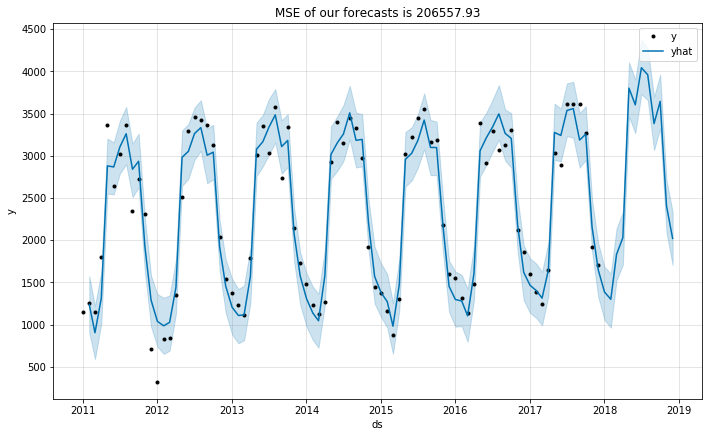

In [20]:
from fbprophet import Prophet

rcParams['font.size'] = default_font_size

df = pd.read_csv('月发电量.csv')
df.reset_index()
df.rename(columns={'date':'ds', '#value':'y'}, inplace=True)
#df['y'] = np.log(df['y'])
m = Prophet()
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(df)

future = m.make_future_dataframe(periods=12, freq='M')
#这段代码主要是上面的代码对时间的月频率处理有bug
future2 = pd.DataFrame(data=[pd.tslib.Timestamp('2018-01-01 00:00:00'),
                             pd.tslib.Timestamp('2018-02-01 00:00:00'), 
                             pd.tslib.Timestamp('2018-03-01 00:00:00'), 
                             pd.tslib.Timestamp('2018-04-01 00:00:00'), 
                             pd.tslib.Timestamp('2018-05-01 00:00:00'), 
                             pd.tslib.Timestamp('2018-06-01 00:00:00'), 
                             pd.tslib.Timestamp('2018-07-01 00:00:00'), 
                             pd.tslib.Timestamp('2018-08-01 00:00:00'), 
                             pd.tslib.Timestamp('2018-09-01 00:00:00'), 
                             pd.tslib.Timestamp('2018-10-01 00:00:00'),
                             pd.tslib.Timestamp('2018-11-01 00:00:00'), 
                             pd.tslib.Timestamp('2018-12-01 00:00:00')],
                     index=range(84, 96), columns=['ds'])
old = future.iloc[1:84]
ff = pd.concat([old, future2])
forecast = m.predict(ff)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-12:-10])
m.plot(forecast);

y_forecasted_d = forecast[['yhat']]

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_forecasted_d[-12:], y_truth_d[-12:])

plt.title('MSE of our forecasts is %.2f' %(mse))
plt.legend()

图上的黑点是实际的发电量，蓝色曲线是预测拟合曲线，阴影部分是预测误差范围。计算的结果和ARIMA相差较大，但因为这个库里面有很多参数未完全调优，结果仅供参考。

# 线性回归模型

首先我们假设本月发电量和去年该月份、去年的该月前两个月、本年前三个月发电量有关系，所以对于每一行的数据，分别获取它前一月、前两月、前三月对应的数据存在本行，此外获取它前十二个月（一年）、前十三个月、前十四个月对应的数据存在本行，分别以属性_index来命名。

**注意：该模型预测这类时序数据可能准确率不会太高，仅作为参考**。

In [21]:
def derive_nth_month_feature(df, feature, N):  
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements


ds = data.copy()
ds.rename(columns={'date':'ds', '#value':'y'}, inplace=True)
for N in range(1, 4):
    derive_nth_month_feature(ds, 'y', N)
for N in range(12, 15):
    derive_nth_month_feature(ds, 'y', N)
ds = ds.dropna()
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
y,70.0,2389.069571,919.725135,838.74,1478.7675,2622.795,3282.5100,3616.62
y_1,70.0,2376.538571,935.020318,828.45,1457.4525,2622.795,3282.5100,3616.62
y_2,70.0,2353.690571,965.334534,322.77,1402.7475,2622.795,3282.5100,3616.62
y_3,70.0,2317.141571,978.652856,322.77,1381.1700,2342.550,3271.5375,3616.62
y_12,70.0,2318.491429,946.514609,322.77,1397.0775,2430.015,3211.6875,3572.73
y_13,70.0,2309.905429,953.419550,322.77,1373.6100,2430.015,3211.6875,3572.73
y_14,70.0,2295.946571,963.314468,322.77,1356.2850,2430.015,3211.6875,3572.73


接下来分析相关性，调用corr方法选择我感兴趣的数据，然后再对返回的结果调用排序最终输出从最负相关到最正相关的相关值。

In [22]:
ds.corr()[['y']].sort_values('y')

,y
y_3,0.038368
y_2,0.419512
y_14,0.444135
y_13,0.742382
y_1,0.755691
y_12,0.928331
y,1.000000


从上述输出我们看出y_3（前三个月）相关性不大，实际上y_2&y_14相关性小于0.5也不大，不过暂时保留。接下来用假设检验验证所研究数据假设的重要性。

In [23]:
fetures = ['y_12','y_1','y_13','y_14','y_2']

x1 = ds[fetures]
X1 = sm.add_constant(x1)
y = ds['y']

# 模型检验
alpha = 0.05
model = sm.OLS(y, X1).fit()
model.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     95.72
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           2.37e-28
Time:                        10:11:24   Log-Likelihood:                -501.70
No. Observations:                  70   AIC:                             1015.
Df Residuals:                      64   BIC:                             1029.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        164.6666    124.700      1.320      0.191     -84.451     413.784
y_12           0.7919      0.070     11.302      0.000       0.652       0.932
y_1            0.3124      0.131      2.392      0.020       0.052       0.573
y_13          -0.1405      0.124     -1.136      0.260      -0.388       0.107
y_14          -0.0244      0.115     -0.211      0.833      -0.255       0.206
y_2            0.0113      0.121      0.093      0.926      -0.230       0.253
==============================================================================
Omnibus:                        1.350   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.509   Jarque-Bera (JB):                1.340
Skew:                           0.316   Prob(JB):                        0.512
Kurtosis:                       2.755   Cond. No.                     1.76e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

通过输出可以看出，y_13,y_14,y_2都不满足p值检验。去掉之后再检验。

In [24]:
fetures = ['y_12','y_1']
X = ds[fetures]

# 模型检验
model = sm.OLS(y, X).fit()
model.summary() 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     2101.
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           7.40e-62
Time:                        10:11:24   Log-Likelihood:                -503.71
No. Observations:                  70   AIC:                             1011.
Df Residuals:                      68   BIC:                             1016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y_12           0.7988      0.057     14.106      0.000       0.686       0.912
y_1            0.2178      0.056      3.923      0.000       0.107       0.329
==============================================================================
Omnibus:                        0.537   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.764   Jarque-Bera (JB):                0.610
Skew:                           0.196   Prob(JB):                        0.737
Kurtosis:                       2.764   Cond. No.                         7.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

从输出中看到，所有其余的预测变量的p值显着低于我们的0.05，已经满足要求。下面使用线性回归模型来进行预测，把训练和测试数据集分成80％的训练和20％的测试。

In [32]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression  

# 划分训练数据和测试数据
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.17, random_state=12) 

regressor = LinearRegression()
regressor.fit(X_train, y_train)

# 输出计算的参数
print('coef : ', regressor.coef_)

# 使用测试数据集来预测
prediction = regressor.predict(X_test)

# 输出预测精度信息
from sklearn.metrics import mean_squared_error, median_absolute_error  
print("The Explained Variance: %.2f" % regressor.score(X_test, y_test))  
print("The Mean Squared Error: %.2f degrees celsius" 
      % mean_squared_error(y_test, prediction))  
print("The Median Absolute Error: %.2f degrees celsius" 
      % median_absolute_error(y_test, prediction))

coef :  [ 0.7282944   0.21802621]
The Explained Variance: 0.89
The Mean Squared Error: 89726.29 degrees celsius
The Median Absolute Error: 144.34 degrees celsius


在这里拟合的效果不好，考虑使用多元多项式来拟合看看效果，即y=ax + bx ^ 2这样多公式。

In [39]:
from sklearn.preprocessing import PolynomialFeatures

quadratic_featurizer = PolynomialFeatures(degree=2) 
# 用二次多项式对样本X值做变换
X_train_quadratic = quadratic_featurizer.fit_transform(X_train) 

regressor_quadratic = LinearRegression() 
# 以多项式变换后的x值为输入，代入线性回归模型做训练
regressor_quadratic.fit(X_train_quadratic, y_train) 

# 输出计算的参数
print('coef : ', regressor_quadratic.coef_)

# 使用测试数据集来预测
X_test_quadratic = quadratic_featurizer.fit_transform(X_test) 
test_prediction_quadratic = regressor_quadratic.predict(X_test_quadratic)
print("The Explained Variance: %.2f" % regressor_quadratic.score(X_test_quadratic, y_test))  
print("The Mean Squared Error: %.2f degrees celsius" 
      % mean_squared_error(y_test, test_prediction_quadratic))  
print("The Median Absolute Error: %.2f degrees celsius" 
      % median_absolute_error(y_test, test_prediction_quadratic))

coef :  [  0.00000000e+00   4.55925528e-01   8.38850615e-01   9.19157044e-05
  -6.18416848e-05  -1.01755189e-04]
The Explained Variance: 0.88
The Mean Squared Error: 94911.62 degrees celsius
The Median Absolute Error: 178.95 degrees celsius


从输出结果看精度还不如一元多项式，接下来同样使用训练好的模型对2018年1月份和2月份的发电量进行预测，计算方式如下：

In [26]:
Jan = pd.date_range('20180101', periods=1, freq='D')
JanValue = np.zeros((1,2))
JanValue[0][0] = 1601.88
JanValue[0][1] = 1705.62
X_Jan = pd.DataFrame(JanValue, index=Jan, columns=['y_12','y_1'])
JanForcasted = regressor.predict(X_Jan)

Feb = pd.date_range('20180201', periods=1, freq='D')
FebValue = np.zeros((1,2))
FebValue[0][0] = 1386.84
FebValue[0][1] = JanForcasted[0]
X_Feb = pd.DataFrame(FebValue, index=Feb, columns=['y_12','y_1'])
FebForcasted = regressor.predict(X_Feb)
#print(ds['20170201':'20170201']['y'])

print('线性回归预测2018年一月份发电量为：%.2f, 二月份发电量为：%.2f'
      %(JanForcasted[0], FebForcasted[0]))

线性回归预测2018年一月份发电量为：1707.23, 二月份发电量为：1550.97


# 总结

上述几种算法预测的2018年一月和二月份发电量如列表所示：


| 算法名称| 一月预测 | 二月预测 | MSE |
| ------| ------ | ------ |  ------ | 
| ARIMA | 1528.71 | 1323.49 | 63371|
| SARIMAX | 1531.97 | 1386.08 | 44198 |
| Prophet | 1385.60 | 1299.50 | 206557|
| LR | 1707.23 | 1550.97 | 89720|

上述四个算法如果仅看MSE的话，SARIMAX是误差最小的算法，但总的看来结果都不是很理想，只是其结果相对误差更小而已。